In [1]:
import tensorflow as tf
import datetime
import janitor

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [31]:
# Importando dataset
df = pd.read_csv('Dados\Loja_10_Unificado.csv')

In [32]:
df.head()

,data,loja,receita,desconto,receita_liquida,cliente,gorjeta,maxtempC,mintempC,cloudcover,...,feriado_Dia dos Pais,feriado_Finados,feriado_Independência,feriado_Natal,feriado_Nsa. Sra. Aparecida,feriado_Paixão de Cristo,feriado_Proclamação da República,feriado_Páscoa,feriado_Tiradentes,feriado_Véspera Ano Novo
0,2015-01-01,1490,19020.5000,407.2100,18613.2900,282,0.0000,28,20,54,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2015-01-02,770,11059.5000,305.1400,10754.3600,172,0.0000,30,21,41,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2015-01-03,890,11363.5000,265.9300,11097.5700,169,0.0000,27,20,87,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,2015-01-04,1490,18256.5000,264.0600,17992.4400,275,0.0000,25,20,90,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,2015-01-05,930,11094.5000,505.3200,10589.1800,181,0.0000,27,19,73,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [33]:
df=df.fillna(0)

In [34]:
lags = 8
for i in range(1,lags):
    df['lag_'+str(i)] = df['cliente'].shift(i)

In [35]:
df.dropna()

,data,loja,receita,desconto,receita_liquida,cliente,gorjeta,maxtempC,mintempC,cloudcover,...,feriado_Páscoa,feriado_Tiradentes,feriado_Véspera Ano Novo,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,2015-01-08,1420,16842.3000,841.6100,16000.6900,256,0.0000,30,19,15,...,0.0000,0.0000,0.0000,228.0000,198.0000,181.0000,275.0000,169.0000,172.0000,282.0000
8,2015-01-09,1380,15366.5000,1073.5400,14292.9600,236,0.0000,31,20,15,...,0.0000,0.0000,0.0000,256.0000,228.0000,198.0000,181.0000,275.0000,169.0000,172.0000
9,2015-01-10,1240,16465.9000,251.8000,16214.1000,227,0.0000,30,20,16,...,0.0000,0.0000,0.0000,236.0000,256.0000,228.0000,198.0000,181.0000,275.0000,169.0000
10,2015-01-11,1380,20494.0000,339.9600,20154.0400,296,0.0000,32,20,15,...,0.0000,0.0000,0.0000,227.0000,236.0000,256.0000,228.0000,198.0000,181.0000,275.0000
11,2015-01-12,1030,11190.0000,122.0400,11067.9600,171,0.0000,32,21,15,...,0.0000,0.0000,0.0000,296.0000,227.0000,236.0000,256.0000,228.0000,198.0000,181.0000
12,2015-01-13,1310,16715.0000,413.2600,16301.7400,246,0.0000,29,21,11,...,0.0000,0.0000,0.0000,171.0000,296.0000,227.0000,236.0000,256.0000,228.0000,198.0000
13,2015-01-14,1340,14351.0000,950.1900,13400.8100,220,0.0000,32,20,9,...,0.0000,0.0000,0.0000,246.0000,171.0000,296.0000,227.0000,236.0000,256.0000,228.0000
14,2015-01-15,1460,17564.5000,659.2300,16905.2700,265,0.0000,30,20,24,...,0.0000,0.0000,0.0000,220.0000,246.0000,171.0000,296.0000,227.0000,236.0000,256.0000
15,2015-01-16,1590,17559.0000,1338.2800,16220.7200,264,0.0000,32,20,42,...,0.0000,0.0000,0.0000,265.0000,220.0000,246.0000,171.0000,296.0000,227.0000,236.0000
16,2015-01-17,1050,13288.0000,153.5500,13134.4500,191,0.0000,35,20,46,...,0.0000,0.0000,0.0000,264.0000,265.0000,220.0000,246.0000,171.0000,296.0000,227.0000


In [36]:
df = df.drop(columns=['loja', 'receita', 'receita_liquida', 'gorjeta', 'desconto', 'feriado', 'tipo_feriado'])

In [37]:
df = df.clean_names()

In [38]:
df['data'] = pd.to_datetime(df['data'])
df['cliente'] = pd.to_numeric(df['cliente'], errors='coerce')
df = df.dropna(subset=['cliente'])
df['data']=pd.to_datetime(df['data']) 

df['quarter'] = df['data'].apply(lambda x: x.quarter)
df["weekday"]=df.apply(lambda row: row["data"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

df=df.loc[:,]
df.sort_values('data', inplace=True, ascending=True)
df = df.reset_index(drop=True)

print('Number of rows and columns after removing missing values:', df.shape)
# print('The time series starts from: ', df.date_time.min())
# print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (1793, 46)


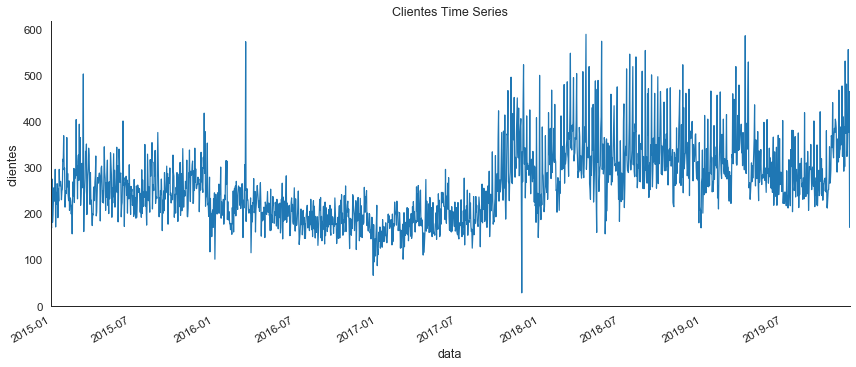

In [11]:
df1=df.loc[:,['data','cliente']]
df1.set_index('data',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('clientes')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Clientes Time Series')
sns.despine(top=True)
plt.show();

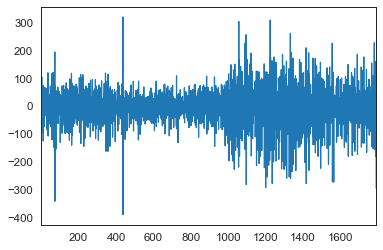

In [39]:
 df.cliente.diff().dropna().plot()

In [40]:
df['cliente'] = df.cliente.diff()
df.dropna()

,data,cliente,maxtempc,mintempc,cloudcover,humidity,precipmm,pressure,windspeedkmph,semana,...,feriado_vespera_ano_novo,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,quarter,weekday
7,2015-01-08,28.0000,30,19,15,79,5.9000,1014,5,3,...,0.0000,228.0000,198.0000,181.0000,275.0000,169.0000,172.0000,282.0000,1,1
8,2015-01-09,-20.0000,31,20,15,76,3.1000,1013,6,4,...,0.0000,256.0000,228.0000,198.0000,181.0000,275.0000,169.0000,172.0000,1,1
9,2015-01-10,-9.0000,30,20,16,78,5.3000,1014,8,5,...,0.0000,236.0000,256.0000,228.0000,198.0000,181.0000,275.0000,169.0000,1,0
10,2015-01-11,69.0000,32,20,15,77,3.2000,1014,4,6,...,0.0000,227.0000,236.0000,256.0000,228.0000,198.0000,181.0000,275.0000,1,0
11,2015-01-12,-125.0000,32,21,15,78,14.9000,1013,5,0,...,0.0000,296.0000,227.0000,236.0000,256.0000,228.0000,198.0000,181.0000,1,1
12,2015-01-13,75.0000,29,21,11,81,8.8000,1013,6,1,...,0.0000,171.0000,296.0000,227.0000,236.0000,256.0000,228.0000,198.0000,1,1
13,2015-01-14,-26.0000,32,20,9,74,2.9000,1014,5,2,...,0.0000,246.0000,171.0000,296.0000,227.0000,236.0000,256.0000,228.0000,1,1
14,2015-01-15,45.0000,30,20,24,75,1.0000,1014,8,3,...,0.0000,220.0000,246.0000,171.0000,296.0000,227.0000,236.0000,256.0000,1,1
15,2015-01-16,-1.0000,32,20,42,79,1.1000,1015,7,4,...,0.0000,265.0000,220.0000,246.0000,171.0000,296.0000,227.0000,236.0000,1,1
16,2015-01-17,-73.0000,35,20,46,75,1.5000,1013,6,5,...,0.0000,264.0000,265.0000,220.0000,246.0000,171.0000,296.0000,227.0000,1,0


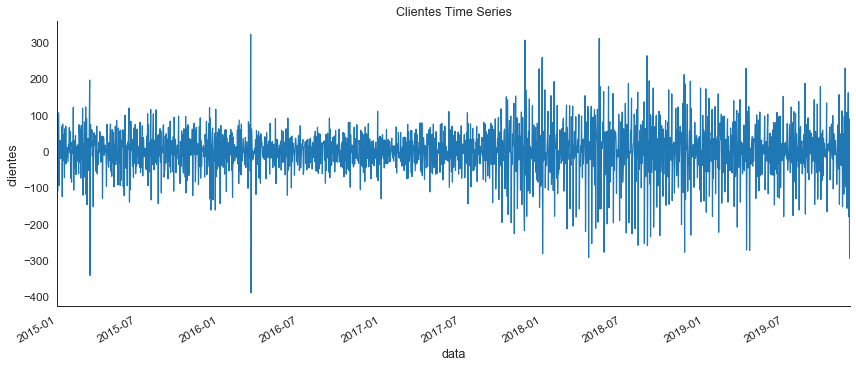

In [41]:
# df1=df.loc[:,['data','cliente']]
# df1.set_index('data',inplace=True)
# df1.plot(figsize=(12,5))
# plt.ylabel('clientes')
# plt.legend().set_visible(False)
# plt.tight_layout()
# plt.title('Clientes Time Series')
# sns.despine(top=True)
# plt.show();

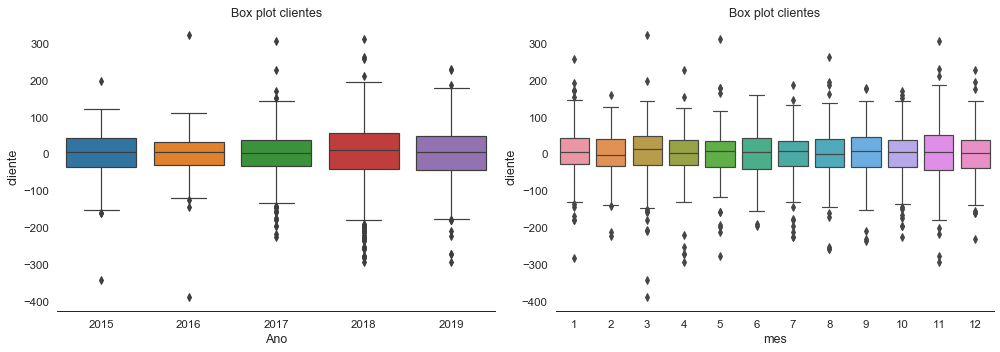

In [42]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="ano", y="cliente", data=df)
plt.xlabel('Ano')
plt.title('Box plot clientes')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="mes", y="cliente", data=df)
plt.xlabel('mes')
plt.title('Box plot clientes')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
cliente,1792.0000,-0.0625,73.1034,-390.0000,-35.0000,4.0000,41.0000,322.0000


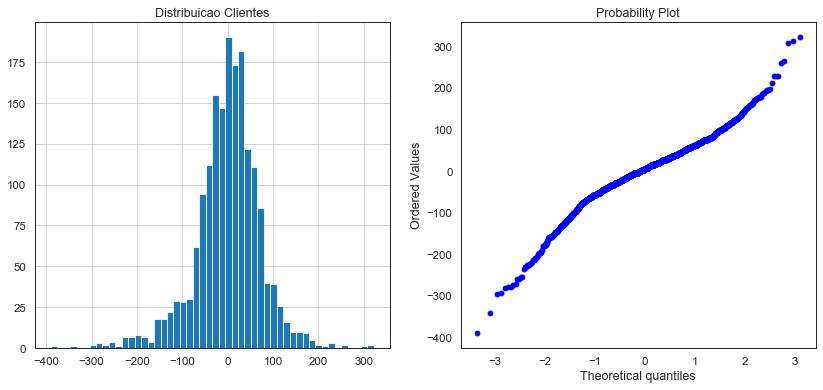

In [43]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['cliente'].hist(bins=50)
plt.title('Distribuicao Clientes')
plt.subplot(1,2,2)
stats.probplot(df['cliente'], plot=plt);
df1.describe().T

In [44]:
df.cliente = np.log(df.cliente)

ValueError: supplied range of [-inf, 5.7745515455444085] is not finite

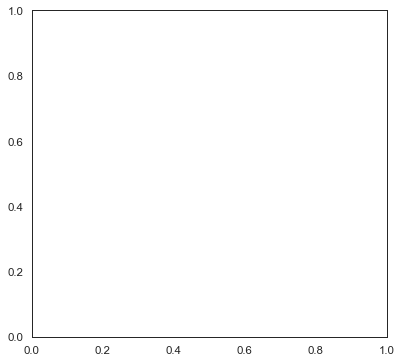

In [46]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['cliente'].hist(bins=50)
plt.title('Distribuicao Clientes')
plt.subplot(1,2,2)
stats.probplot(df['cliente'], plot=plt);
df1.describe().T

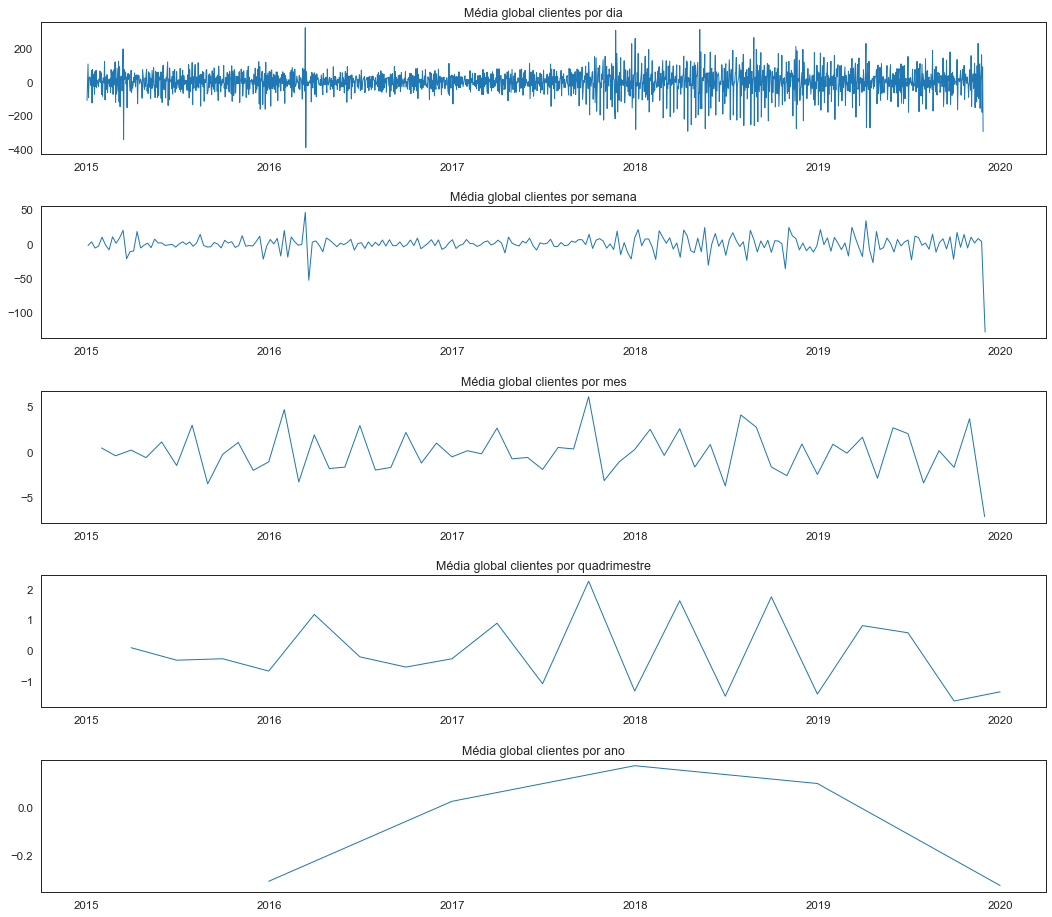

In [47]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['cliente'].resample('D').mean(),linewidth=1)
ax1.set_title('Média global clientes por dia')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['cliente'].resample('W').mean(),linewidth=1)
ax2.set_title('Média global clientes por semana')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['cliente'].resample('M').mean(),linewidth=1)
ax3.set_title('Média global clientes por mes')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['cliente'].resample('Q').mean(),linewidth=1)
ax4.set_title('Média global clientes por quadrimestre')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['cliente'].resample('A').mean(),linewidth=1)
ax5.set_title('Média global clientes por ano')
ax5.tick_params(axis='both', which='major');

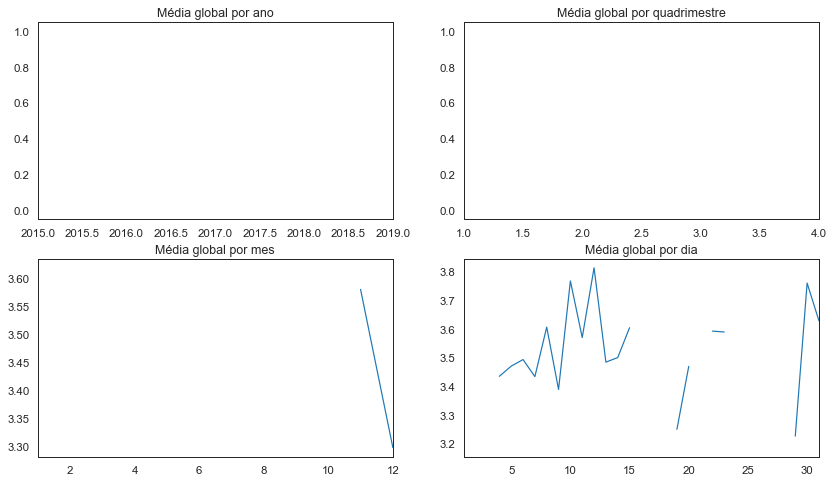

In [49]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('ano').cliente.agg('mean').plot()
plt.xlabel('')
plt.title('Média global por ano')

plt.subplot(2,2,2)
df.groupby('quarter').cliente.agg('mean').plot()
plt.xlabel('')
plt.title('Média global por quadrimestre')

plt.subplot(2,2,3)
df.groupby('mes').cliente.agg('mean').plot()
plt.xlabel('')
plt.title('Média global por mes')

plt.subplot(2,2,4)
df.groupby('dia').cliente.agg('mean').plot()
plt.xlabel('')
plt.title('Média global por dia');

In [21]:
# pd.pivot_table(df.loc[df['ano'] != 2006], values = "cliente", 
#                columns = "ano", index = "mes").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

In [50]:
pd.pivot_table(df.loc[df['ano']], values = "cliente", 
               columns = "ano", index = "mes").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

KeyError: "None of [Int64Index([2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,\n            ...\n            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],\n           dtype='int64', length=1793)] are in the [index]"

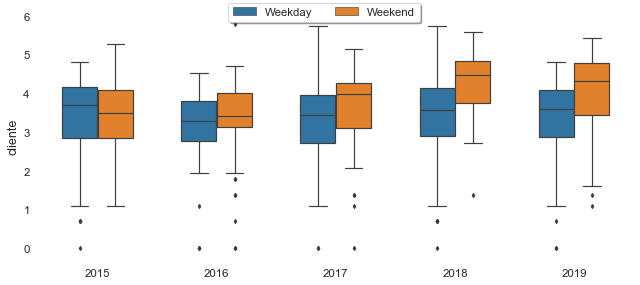

In [51]:
dic={0:'Weekend',1:'Weekday'}
df['dia'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('ano','cliente',hue='dia',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

ValueError: Invalid RGBA argument: masked

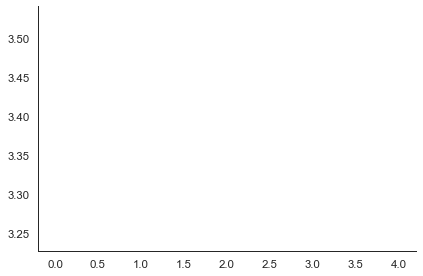

In [52]:
plt1=sns.factorplot('ano','cliente',hue='dia',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot clientes por Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

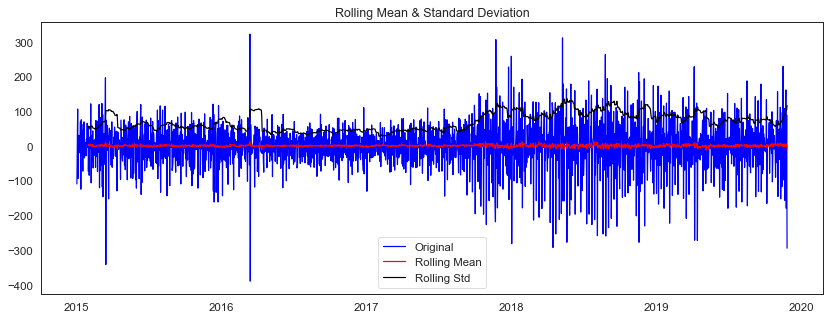

<Results of Dickey-Fuller Test>
Test Statistic                 -13.7086
p-value                          0.0000
#Lags Used                      20.0000
Number of Observations Used   1770.0000
Critical Value (1%)             -3.4340
Critical Value (5%)             -2.8632
Critical Value (10%)            -2.5676
dtype: float64


In [53]:
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.cliente.dropna())

In [26]:
dataset = df.cliente.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [27]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'], )

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Dense(512, activation=tf.nn.relu), # 512 neuronios fully connected com ativação por ReLU
#   tf.keras.layers.Dropout(0.2),# Dropout de 20% da última camada
#   tf.keras.layers.Dense(256, activation=tf.nn.relu),
#   tf.keras.layers.Dropout(0.2),
  # tf.keras.layers.Dense(10, activation=tf.nn.softmax) # 10 neurônios softmax, para classificação. Um para cada categoria
# ])

history = model.fit(X_train, Y_train, epochs=200, batch_size=250, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()


Train on 1403 samples, validate on 328 samples
Epoch 1/200
1403/1403 [==============================] - 1s 450us/step - loss: 0.1287 - accuracy: 0.0000e+00 - val_loss: 0.0616 - val_accuracy: 0.0000e+00
Epoch 2/200
1403/1403 [==============================] - 0s 43us/step - loss: 0.0509 - accuracy: 0.0000e+00 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 3/200
1403/1403 [==============================] - 0s 46us/step - loss: 0.0145 - accuracy: 0.0000e+00 - val_loss: 0.0302 - val_accuracy: 0.0000e+00
Epoch 4/200
1403/1403 [==============================] - 0s 46us/step - loss: 0.0167 - accuracy: 0.0000e+00 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 5/200
1403/1403 [==============================] - 0s 46us/step - loss: 0.0083 - accuracy: 0.0000e+00 - val_loss: 0.0090 - val_accuracy: 0.0000e+00
Epoch 6/200
1403/1403 [==============================] - 0s 46us/step - loss: 0.0088 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 7/200
1403/1403 [====

Epoch 52/200
1403/1403 [==============================] - 0s 40us/step - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 53/200
1403/1403 [==============================] - 0s 43us/step - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 54/200
1403/1403 [==============================] - 0s 43us/step - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 55/200
1403/1403 [==============================] - 0s 43us/step - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 56/200
1403/1403 [==============================] - 0s 46us/step - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 57/200
1403/1403 [==============================] - 0s 77us/step - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 58/200
1403/1403 [==============================] - 0s 268us/ste

1403/1403 [==============================] - 0s 225us/step - loss: 0.0040 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 105/200
1403/1403 [==============================] - 0s 245us/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 106/200
1403/1403 [==============================] - 0s 256us/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 107/200
1403/1403 [==============================] - 0s 253us/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 108/200
1403/1403 [==============================] - 0s 225us/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 109/200
1403/1403 [==============================] - 0s 268us/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 110/200
1403/1403 [==============================] - 0s 262us/step

1403/1403 [==============================] - 0s 231us/step - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 157/200
1403/1403 [==============================] - 0s 205us/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 158/200
1403/1403 [==============================] - 0s 219us/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 159/200
1403/1403 [==============================] - 0s 211us/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 160/200
1403/1403 [==============================] - 0s 219us/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 161/200
1403/1403 [==============================] - 0s 214us/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 162/200
1403/1403 [==============================] - 0s 268us/step

In [28]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.1393263861378598
Train Root Mean Squared Error: 0.1909273534218898
Test Mean Absolute Error: 0.12869224926878178
Test Root Mean Squared Error: 0.1584024381584799


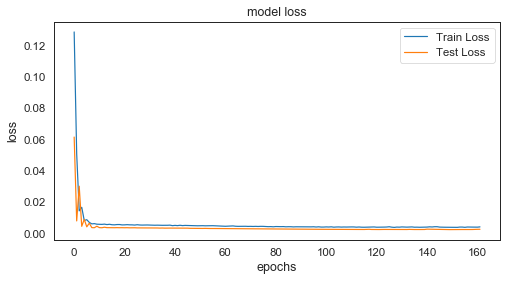

In [29]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

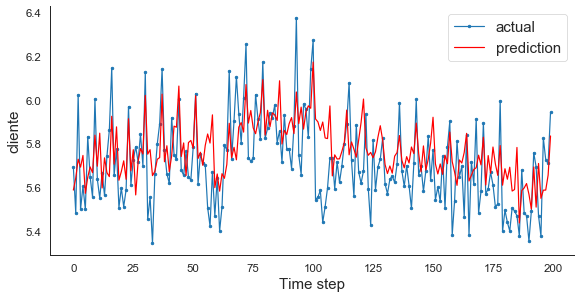

In [30]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('cliente', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),df,color='b',label='True')
plt.plot(range(0,N),model,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()